
image 1/1 /home/bg9287/object_detection/test_image_path.png: 640x544 1 Tibia, 19.6ms
Speed: 2.2ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)
Rotated 13.60799597325449 degrees

image 1/1 /home/bg9287/object_detection/test_image_path.png: 640x544 1 Tibia, 19.2ms
Speed: 2.5ms preprocess, 19.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /home/bg9287/object_detection/test_image_path.png: 640x544 1 Tibia, 19.6ms
Speed: 2.2ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /home/bg9287/object_detection/test_image_path.png: 640x544 1 Tibia, 19.6ms
Speed: 2.3ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)
Tibia Midline Angle: -88.4359649058567 degrees
Distal Tibial Articular Angle: 84.59130048256375 degrees
Talar Center Migration Angle: 74.50427566405372 degrees
Talar Tilt Angle: 88.31432924233286 degrees


<function matplotlib.pyplot.show(close=None, block=None)>

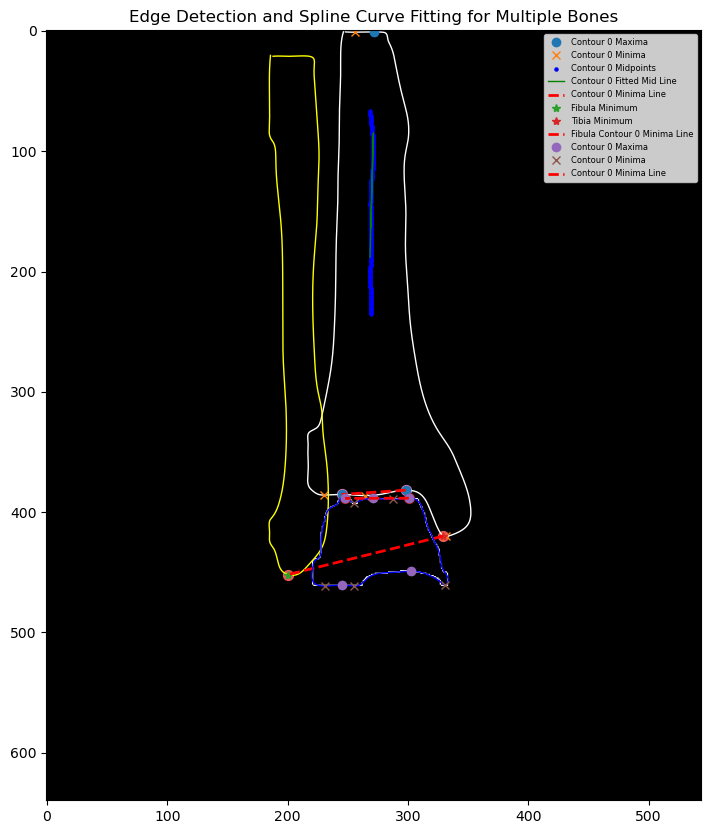

In [45]:
# Import statements
from ultralytics import YOLO
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.signal import find_peaks
import random
import csv
from sklearn.linear_model import LinearRegression
from math import atan2, degrees
import matplotlib.patches as patches
import matplotlib as mpl
import math
from math import hypot

# Specify paths to each model
fib_model = YOLO("runs/segment/train10/weights/best.pt")
tib_model = YOLO("runs/segment/train9/weights/best.pt")
tal_model = YOLO("runs/segment/train11/weights/best.pt")

# Path to image to be analyzed
image_path = "images/test/transformed_image_1131_5.png"

# Function to rotate image if its angle is too intense
def rotate_image(image_path):
    # Border the image
    unbordered_image = Image.open(image_path)
    old_size = unbordered_image.size
    old_w, old_h = unbordered_image.size
    
    new_size = (old_w + 50, old_h + 50)
    bordered_image = Image.new("RGB", new_size)   ## luckily, this is already black!
    box = tuple((n - o) // 2 for n, o in zip(new_size, old_size))
    bordered_image.paste(unbordered_image, box)
    test_image_path = "test_image_path.png"
    bordered_image.save(test_image_path)

    # Find the tibia contour
    tib_results = tib_model.predict(test_image_path)
    tib_result = tib_results[0]
    tib_masks = tib_result.masks
    tib_mask1 = tib_masks[0]
    tib_mask = tib_mask1.data[0]
    tib_mask = tib_mask.cpu().numpy()
    tib_mask_img = Image.fromarray(tib_mask,"I")
    tib_output_path = "tibia_temp_path.png"
    tib_mask_img.save(tib_output_path)
    tib_image = cv2.imread(tib_output_path, cv2.IMREAD_GRAYSCALE)
    tib_edges = cv2.Canny(tib_image, 100, 200)
    tib_contours, _ = cv2.findContours(tib_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Open the contour (tibia)
    with open('spline_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ContourIndex', 'X', 'Y'])
    
        # Process each contour
        for contour_index, contour in enumerate(tib_contours):
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
    
            if (area/perimeter) < 2:
                print('Open Contour')
                #contour = close_contour(contour)
            
            x_coords = contour[:, 0, 0]
            y_coords = contour[:, 0, 1]
    
            # Fit a spline to the edge coordinates tibia
            tck, u = splprep([x_coords, y_coords], s=100)  # Adjusted smoothing parameter
            u_new = np.linspace(u.min(), u.max(), 1000)
            x_new, y_new = splev(u_new, tck)
    
            # Plot the spline with a random color
    
            # Save the spline data to the CSV file
            for x, y in zip(x_new, y_new):
                writer.writerow([contour_index, x, y])
    
            # Calculate midpoints
            midpoints_x = []
            midpoints_y = []
            
            for i in range(len(x_new) // 2):
                mid_x = (x_new[i] + x_new[-(i+1)]) / 2
                mid_y = (y_new[i] + y_new[-(i+1)]) / 2
                midpoints_x.append(mid_x)
                midpoints_y.append(mid_y)
    
            # Select the central segment of midpoints
            midpoint_length = len(midpoints_x)
            segment_start =  midpoint_length // 6
            segment_end = 3 * midpoint_length // 6
            central_midpoints_x = midpoints_x[segment_start:segment_end]
            central_midpoints_y = midpoints_y[segment_start:segment_end]
    
            # Fit a line to the central midpoints
            central_midpoints_x = np.array(central_midpoints_x).reshape(-1, 1)
            central_midpoints_y = np.array(central_midpoints_y)
            reg = LinearRegression().fit(central_midpoints_x, central_midpoints_y)
            slope_midline = reg.coef_[0]
            intercept_midline = reg.intercept_
            angle_midline = degrees(np.arctan(slope_midline))
            img = Image.open(image_path)

            # Rotate image based on midline angle if it is too far off
            if abs(abs(angle_midline) - 90) > 10:
                if angle_midline > 0:
                    rotated_img = img.rotate(1*(angle_midline - 90))
                    print(f"Rotated {(angle_midline - 90)} degrees")
                else:
                    rotated_img = img.rotate(1*(angle_midline + 90))
                    print(f"Rotated {(angle_midline + 90)} degrees")
    
                return rotated_img
            else:
                print("No Rotation Needed")
                return img

# rotate image
output_path = "rotated.png"
rotated_img = rotate_image(image_path)
rotated_img.save(output_path)

image_path = output_path

# Border new rotated image
unbordered_image = Image.open(image_path)
old_size = unbordered_image.size
old_w, old_h = unbordered_image.size

new_size = (old_w + 50, old_h + 50)
bordered_image = Image.new("RGB", new_size)   ## luckily, this is already black!
box = tuple((n - o) // 2 for n, o in zip(new_size, old_size))
bordered_image.paste(unbordered_image, box)
test_image_path = "test_image_path.png"
bordered_image.save(test_image_path)

height, width = bordered_image.size

# Get contours for all models (future models can be added)


def get_contours(model, image_path, temp_path):
    #print(model)
    results = model.predict(image_path)
    result = results[0]
    masks = result.masks
    mask1 = masks[0]
    mask = mask1.data[0]
    mask = mask.cpu().numpy()
    mask_img = Image.fromarray(mask,"I")
    output_path = temp_path
    mask_img.save(output_path)
    image = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return (edges, contours)

# Get edges and contours
tib_edges, tib_contours = get_contours(tib_model, test_image_path, "tibia_temp_path.png")
fib_edges, fib_contours = get_contours(fib_model, test_image_path, "fibula_temp_path.png")
tal_edges, tal_contours = get_contours(tal_model, test_image_path, "talus_temp_path.png")

# Prepare the plot
plt.figure(figsize=(10, 10))
plt.imshow(tib_edges, cmap='gray')
plt.imshow(fib_edges, cmap='gray')
plt.imshow(tal_edges, cmap='gray')

# Function to generate a random color
def random_color():
    return [random.random(), random.random(), random.random()]

# Function to find local minima (considered as maxima) and maxima (considered as minima)
def find_local_extrema(x, y):
    minima, _ = find_peaks(-np.array(y))  # Minima become maxima
    maxima, _ = find_peaks(y)  # Maxima become minima
    return minima, maxima

def find_minimum_value_and_location(contour):
    # Convert contour to a 2D array of points
    points = contour[:, 0, :]
    # Find the minimum y-coordinate value and its corresponding x-coordinate
    min_index = np.argmax(points[:, 1])
    min_value = points[min_index, 1]
    min_location = points[min_index]
    return min_value, min_location

def get_first_last_points(contour):
    first_point = contour[0, 0]
    last_point = contour[-1, 0]
    return first_point, last_point

# Function to close the contour with a straight line
def close_contour(contour):
    # Check if contour has at least 2 points
    if len(contour) < 2:
        raise ValueError("Contour must have at least two points")

    # Sort the contour points by y-coordinate (ascending order)
    sorted_contour = sorted(contour, key=lambda x: x[0][1])
    
    # Get the top two points
    top_two_points = sorted_contour[:2]
    
    # Create a new contour that includes the original points plus the line between the top two points
    new_contour = np.array(top_two_points, dtype=np.int32)
    
    # Add the line between the top two points to the new contour
    new_contour = np.vstack((new_contour, np.array([top_two_points[0], top_two_points[1]], dtype=np.int32)))
    
    final_contour = np.vstack([contour, new_contour])
    
    return final_contour

tib_min_x = 0
tib_min_y = 0

fib_min_x = 0
fib_min_y = 0

# Open a CSV file to save the spline data
with open('spline_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ContourIndex', 'X', 'Y'])

    # Process each contour
    for contour_index, contour in enumerate(tib_contours):
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if (area/perimeter) < 2:
            print('Open Contour')
            #contour = close_contour(contour)
        
        x_coords = contour[:, 0, 0]
        y_coords = contour[:, 0, 1]

        # Fit a spline to the edge coordinates tibia
        tck, u = splprep([x_coords, y_coords], s=100)  # Adjusted smoothing parameter
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = splev(u_new, tck)

        # Plot the spline with a random color
        plt.plot(x_new, y_new, color="white", linewidth=1)

        # Save the spline data to the CSV file
        for x, y in zip(x_new, y_new):
            writer.writerow([contour_index, x, y])

        # Find local minima (as maxima) and maxima (as minima)
        minima, maxima = find_local_extrema(x_new, y_new)
        plt.plot(x_new[minima], y_new[minima], "o", label=f'Contour {contour_index} Maxima')
        plt.plot(x_new[maxima], y_new[maxima], "x", label=f'Contour {contour_index} Minima')

        # Calculate midpoints
        midpoints_x = []
        midpoints_y = []
        
        for i in range(len(x_new) // 2):
            mid_x = (x_new[i] + x_new[-(i+1)]) / 2
            mid_y = (y_new[i] + y_new[-(i+1)]) / 2
            midpoints_x.append(mid_x)
            midpoints_y.append(mid_y)

        # Select the central segment of midpoints
        midpoint_length = len(midpoints_x)
        segment_start =  midpoint_length // 6
        segment_end = 3 * midpoint_length // 6
        central_midpoints_x = midpoints_x[segment_start:segment_end]
        central_midpoints_y = midpoints_y[segment_start:segment_end]

        # Fit a line to the central midpoints
        central_midpoints_x = np.array(central_midpoints_x).reshape(-1, 1)
        central_midpoints_y = np.array(central_midpoints_y)
        reg = LinearRegression().fit(central_midpoints_x, central_midpoints_y)
        slope_midline = reg.coef_[0]
        intercept_midline = reg.intercept_
        angle_midline = degrees(np.arctan(slope_midline))
        print(f"Tibia Midline Angle: {angle_midline} degrees")
        
        # Plot the midpoints and the fitted line
        plt.scatter(central_midpoints_x, central_midpoints_y, color='blue', s=5, label=f'Contour {contour_index} Midpoints')
        plt.plot(central_midpoints_x, reg.predict(central_midpoints_x), color='green', linewidth=1, label=f'Contour {contour_index} Fitted Mid Line')

        # Cut the contour in half using a horizontal line at the median y-value
        median_y = np.median(y_new)
        lower_half_indices = np.where(y_new > median_y)[0]
        lower_half_minima = [minim for minim in minima if minim in lower_half_indices]
        lower_half_maxima = [maxima for maxima in maxima if maxima in lower_half_indices]
        
        if len(lower_half_minima) >= 2 and cv2.arcLength(contour,True) > height/4:
            #print(f"Contour anaylized: {contour_index}")
            
            min_value, min_location = find_minimum_value_and_location(contour)
            #print(f"Contour {contour_index}: Minimum value is {min_value} at location {min_location}")
            tib_min_x = min_location[0]
            tib_min_y = min_location[1]
            #print(f"Tibia min x: {tib_min_x}, Tibia min y: {tib_min_y}")
            # Get the two lowest points in the lower half minima
            sorted_minima = sorted(lower_half_minima, key=lambda idx: y_new[idx])
            #bottom_two_indices = sorted_minima[]
            # Calculate slope between these two points
            dist = 0
            count = 1
            while dist < height/50:
                x1, y1 = x_new[sorted_minima[0]], y_new[sorted_minima[0]]
                x2, y2 = x_new[sorted_minima[count]], y_new[sorted_minima[count]]
                dist = math.hypot(x2 - x1, y2 - y1)
                count += 1
            slope_minima = (y2 - y1) / (x2 - x1)
            min_mid_angle = degrees(atan2(slope_minima - slope_midline, 1 + slope_minima * slope_midline))
            
            plt.plot([x1, x2], [y1, y2], 'r--', linewidth=2, label=f'Contour {contour_index} Minima Line')
            plt.scatter([x1, x2], [y1, y2], color=random_color(), s=50)

            # Calculate the angle between the midline slope and the minima line slope
            
            print(f"Distal Tibial Articular Angle: {abs(min_mid_angle)} degrees")

# Open a CSV file to save the spline data
with open('spline_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ContourIndex', 'X', 'Y'])

    # Process each contour
    for contour_index, contour in enumerate(fib_contours):
        if cv2.arcLength(contour,True) > height/3:
            x_coords = contour[:, 0, 0]
            y_coords = contour[:, 0, 1]
    
            # Fit a spline to the edge coordinates
            tck, u = splprep([x_coords, y_coords], s=100)  # Adjusted smoothing parameter
            u_new = np.linspace(u.min(), u.max(), 1000)
            x_new, y_new = splev(u_new, tck)
    
            # Plot the spline with a random color
            plt.plot(x_new, y_new, color="yellow", linewidth=1)
    
            # Save the spline data to the CSV file
            for x, y in zip(x_new, y_new):
                writer.writerow([contour_index, x, y])
    
    
            min_value, min_location = find_minimum_value_and_location(contour)
            #print(f"Contour {contour_index}: Minimum value is {min_value} at location {min_location}")
            fib_min_x = min_location[0]
            fib_min_y = min_location[1]
    
            plt.plot(fib_min_x, fib_min_y, "*", label=f'Fibula Minimum')
            
            #print(f"Fibula min x: {fib_min_x}, Fibula min y: {fib_min_y}")
    
            plt.plot(tib_min_x, tib_min_y, "*", label=f'Tibia Minimum')
    
            x1, y1, x2, y2 = tib_min_x, tib_min_y, fib_min_x, fib_min_y
    
            slope_minima = (y2 - y1) / (x2 - x1)
            min_mid_angle = degrees(atan2(slope_minima - slope_midline, 1 + slope_minima * slope_midline))
    
            print(f"Talar Center Migration Angle: {min_mid_angle} degrees")
                
            plt.plot([x1, x2], [y1, y2], 'r--', linewidth=2, label=f'Fibula Contour {contour_index} Minima Line')
            plt.scatter([x1, x2], [y1, y2], color=random_color(), s=50)
        
with open('spline_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ContourIndex', 'X', 'Y'])

    # Process each contour
    for contour_index, contour in enumerate(tal_contours):
        if cv2.arcLength(contour,True) > height/8:
            #print("talus")
            
            x_coords = contour[:, 0, 0]
            y_coords = contour[:, 0, 1]
    
            # Fit a spline to the edge coordinates
            tck, u = splprep([x_coords, y_coords], s=100)  # Adjusted smoothing parameter
            u_new = np.linspace(u.min(), u.max(), 1000)
            x_new, y_new = splev(u_new, tck)
    
            # Plot the spline with a random color
            plt.plot(x_new, y_new, color="blue", linewidth=1)
    
            # Save the spline data to the CSV file
            for x, y in zip(x_new, y_new):
                writer.writerow([contour_index, x, y])

            minima, maxima = find_local_extrema(x_new, y_new)
            plt.plot(x_new[minima], y_new[minima], "o", label=f'Contour {contour_index} Maxima')
            plt.plot(x_new[maxima], y_new[maxima], "x", label=f'Contour {contour_index} Minima')

            sorted_maxima = sorted(minima, key=lambda idx: y_new[idx])

            dist = 0
            count = 1
            while dist < height/50:
                x1, y1 = x_new[sorted_maxima[0]], y_new[sorted_maxima[0]]
                x2, y2 = x_new[sorted_maxima[count]], y_new[sorted_maxima[count]]
                dist = math.hypot(x2 - x1, y2 - y1)
                count += 1
            slope_talus = (y2 - y1) / (x2 - x1)
            tal_mid_angle = degrees(atan2(slope_talus - slope_midline, 1 + slope_talus * slope_midline))
            
            plt.plot([x1, x2], [y1, y2], 'r--', linewidth=2, label=f'Contour {contour_index} Minima Line')
            plt.scatter([x1, x2], [y1, y2], color=random_color(), s=50)

            print(f"Talar Tilt Angle: {tal_mid_angle} degrees")

plt.title('Edge Detection and Spline Curve Fitting for Multiple Bones')
plt.legend(prop={'size': 6})
plt.savefig('measured_tibia_fibula_talus.png')
plt.show
